In [85]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [87]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [88]:
import random
random.seed(42)
random.shuffle(words)

In [89]:
#build the dataset
block_size = 8 # context length

def build_dataset(words):
    X, y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            y.append(idx)
            context = context[1:] + [idx]

    X = torch.tensor(X)
    y = torch.tensor(y)
    print(X.shape, y.shape)
    return X, y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X_train, y_train = build_dataset(words[:n1])
X_dev, y_dev = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [97]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    #parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    #buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    #calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      xmean = x.mean(dim=dim, keepdim=True)
      xvar = x.var(dim=dim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    #update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IDX):
    self.out = self.weight[IDX]
    #print(self.out.shape)
    return self.out

  def parameters(self):
    return [self.weight]

class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, -1, self.n*C)
    if x.shape[1] == 1:
      x = x.squeeze(dim=1)
    self.out = x
    #print(self.out.shape)
    return self.out

  def parameters(self):
    return []

class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [98]:
torch.manual_seed(42);

In [99]:
n_embd = 24 # the dimensionality of character embedding vector
n_hidden = 128 # the number of neurons in the hidden layer of mlp

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1 #last layer: make it less confident


parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

76579


In [100]:
max_steps = 200000
batch_size = 32
lossi = []

for iter in range(max_steps):

    #minibatch construct
    idx = torch.randint(0, X_train.shape[0], (batch_size, ))
    Xb, yb = X_train[idx], y_train[idx]

    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, yb)


    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if iter < 100000 else 0.01 # lr decay
    for p in parameters:
        p.data += -lr * p.grad


    if iter%10000 == 0:
      print(f'{iter:7d}/{max_steps:7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())

      0/ 200000:  3.3167
  10000/ 200000:  2.0576
  20000/ 200000:  2.0723
  30000/ 200000:  2.5134
  40000/ 200000:  2.1476
  50000/ 200000:  1.7836
  60000/ 200000:  2.2592
  70000/ 200000:  1.9331
  80000/ 200000:  1.6875
  90000/ 200000:  2.0395
 100000/ 200000:  1.7736
 110000/ 200000:  1.8279
 120000/ 200000:  1.6460
 130000/ 200000:  1.7728
 140000/ 200000:  1.6337
 150000/ 200000:  1.6474
 160000/ 200000:  1.8703
 170000/ 200000:  1.6385
 180000/ 200000:  1.6806
 190000/ 200000:  1.9160


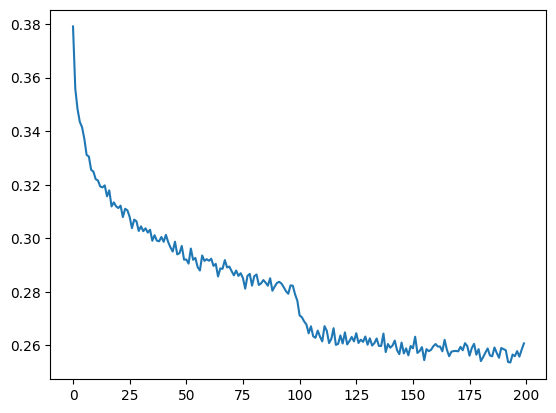

In [101]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1).detach())

In [102]:
for layer in model.layers:
  layer.training = False

In [103]:
@torch.no_grad() # a decorator that disable gradient tracking

def split_loss(s, X, y):
  logits = model(X)
  loss = F.cross_entropy(logits, y)
  print(s, loss.item())

split_loss('train', X_train, y_train)
split_loss('dev', X_dev, y_dev)

train 1.7874855995178223
dev 1.9916560649871826


In [48]:
for i in range(20):
    out = []
    context = [0]*block_size #initialize with all ...
    while True:
        logits = model(torch.tensor([context])) #(1, block_size, n_embd)
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [idx]
        if idx == 0:
            break
        out.append(itos[idx])
    print(''.join(ch for ch in out))

yeverie
kya
kylek
tiskin
porbyn
abib
meriana
zailynn
rayni
dakeya
yare
koren
kamilah
ywen
mirabella
oluwase
josusan
ramiel
ellio
delina


In [8]:
range(10)

range(0, 10)

In [11]:
e = torch.randn(4, 8, 10)
e.shape

torch.Size([4, 8, 10])

In [22]:
explicit = torch.cat((e[:, ::2, :], e[:, 1::2, :]), dim=2)

In [24]:
torch.all(e.view(4,4,20) == explicit)

tensor(True)